# How to map a horizon in 3-D

This tutorial describes how to map stratigraphic horizons in a 3-D seismic volume using a variety of models. We start of really simple with a linear model prediction the depth (twt) of a horizon from a 1-D seismic trace. Then we explore the use of 1-D convolutional neural networks (CNN) for this task. Next, we go to two dimensions giving our model an idea of the surrounding traces.

## Setup ##
1. First, you will need sign in to your Google account. If you're not signed in, you can sign in [here](https://myaccount.google.com/?utm_source=sign_in_no_continue)
2. Next, head on to the [Colab Welcome Page](https://colab.research.google.com/notebooks/welcome.ipynb#recent=true).
3. There, select Github in the top tab and search for https://github.com/thilowrona/seismic_deep_learning/blob/master/tutorial-4/tutorial-4.ipynb
4. Clicking opens this notebook. This is a Jupyter notebook; an awesome combination of code and documentation allowing us work on, describe and share our projects.
5. Before running anything in here, you need to tell Colab that would like to use a GPU (important to train our models quickly). This is done by clicking on the ‘Runtime’ tab, selecting ‘Change runtime type’, changing hardware accelerator to ´GPU´ and clicking ´save´. Excellent! Colab is now set up!
6. When you run the first cell, you will face a pop-up saying ‘Warning: This notebook was not authored by Google’; you should click on ‘Run Anyway’ to get rid of the warning.
7. Next we want to save our notebook. If you click on ‘File’ and then ‘Save’, you will see a pop-up saying ´CANNOT SAVE CHANGES´. Now, click on ‘SAVE A COPY IN DRIVE’. This opens up a new tab with the same file, but this time located in your Drive. If you want to continue working after saving, use the file in the new tab. Your notebook will be saved in a folder called Colab Notebooks in your Google Drive by default.


In [ ]:
!pip install googledrivedownloader
!pip install segpy

In [ ]:
from sys import stdout

import random
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


from PIL import Image

import tensorflow as tf
from tensorflow import keras

from google_drive_downloader import GoogleDriveDownloader as gdd

import segpy
from segpy.reader import create_reader

from scipy.ndimage import gaussian_filter

from google.colab import widgets

and download the 3-D seismic volume and the horizon:

In [ ]:
gdd.download_file_from_google_drive(file_id='196UkQqciaAkS9P78lbIPr39Qf_DvlcBN',
                                    dest_path='./Seismic_data.sgy',
                                    unzip=False)

gdd.download_file_from_google_drive(file_id='15o_M_BWTS_Y9TXen4IYVmdJFz0xbUk3i',
                                    dest_path='./horizon.txt',
                                    unzip=False)

and load the data:

In [ ]:
filename = "./Seismic_data.sgy"
    
with open(filename, 'rb') as segy:
    segy_reader = segpy.reader.create_reader(segy)
    data = np.zeros((segy_reader.num_inlines(), segy_reader.num_trace_samples(1), segy_reader.num_xlines()))
    for inline_num, xline_num in segy_reader.inline_xline_numbers():
        trace_index = segy_reader.trace_index((inline_num, xline_num))        
        inline_start = segy_reader.inline_numbers()[0]
        xline_start  = segy_reader.xline_numbers()[0]        
        data[inline_num-inline_start,:,xline_num-xline_start] = segy_reader.trace_samples(trace_index)

scale the data:

In [ ]:
data = (data-np.min(data))/(np.max(data)-np.min(data))

and sort the data by inlines, crosslines and times:

In [ ]:
data = np.swapaxes(data, 1, 2)

(inlines, xlines, times) = data.shape

Next we load the interpretation:

In [ ]:
# Load interpretation
t_0            = 2
time_range     = 1848
scaling_factor = data.shape[2]/time_range

# Load horizon saved as Kingdom interpretation (ascii)
f=open('./horizon.txt',"r")
lines=f.readlines()

t = []
for line in lines:
    t.append((float(line.split()[4])-t_0)*data.shape[2]/time_range)
f.close()

t = np.array(t).reshape((651, 951))

plot it:

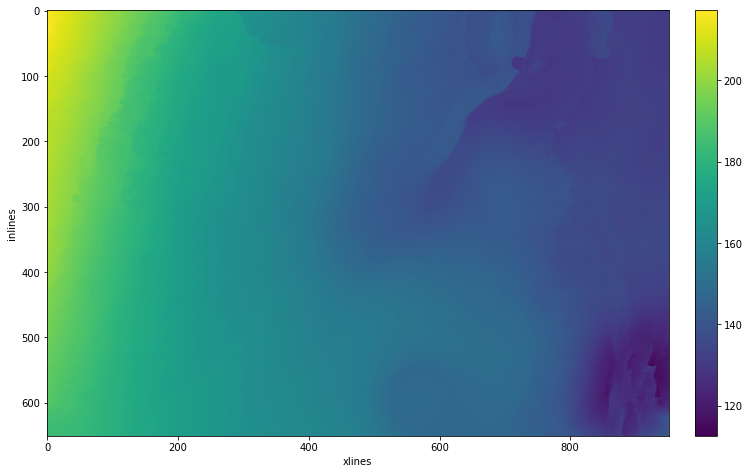

In [ ]:
plt.figure(figsize=(12,12))
plt.imshow(t)
plt.colorbar(fraction=0.0318, pad=0.04)
plt.xlabel('xlines')
plt.ylabel('inlines')
plt.show()

Now we calculate a scaling factor between the seismic data and the horizon in two-way traveltime and plot them together:

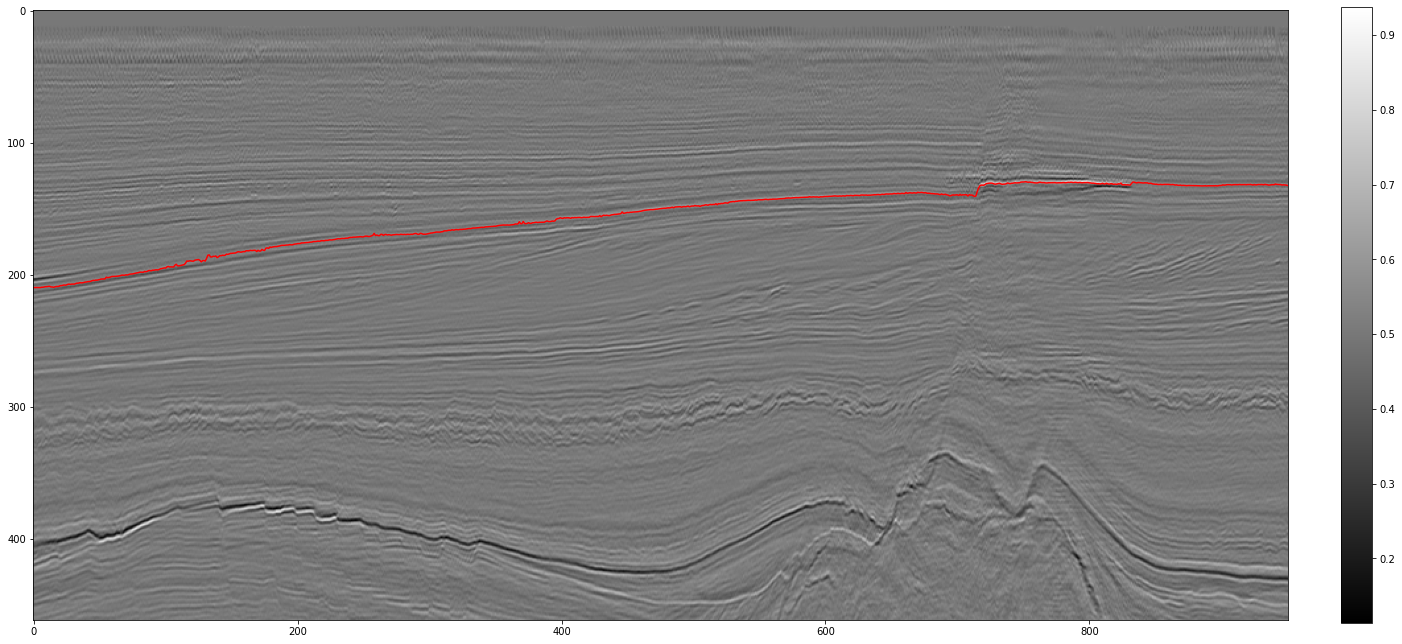

In [ ]:

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[100,:,:]), 'gray')
plt.plot(t[100,:], 'red')
plt.colorbar(fraction=0.023, pad=0.04)
plt.show()

# Linear model #

First we start with a simple linear model predicing the depth (twt) of the horizone from the vertical seismic trace. We train the model using the traces from inline 100:

In [ ]:
from sklearn import linear_model

inline = 100
X = data[inline,:,:]
y = t[inline,:]

lin   = linear_model.LinearRegression().fit(X, y)

Now we can look at our prediction on inline 100:

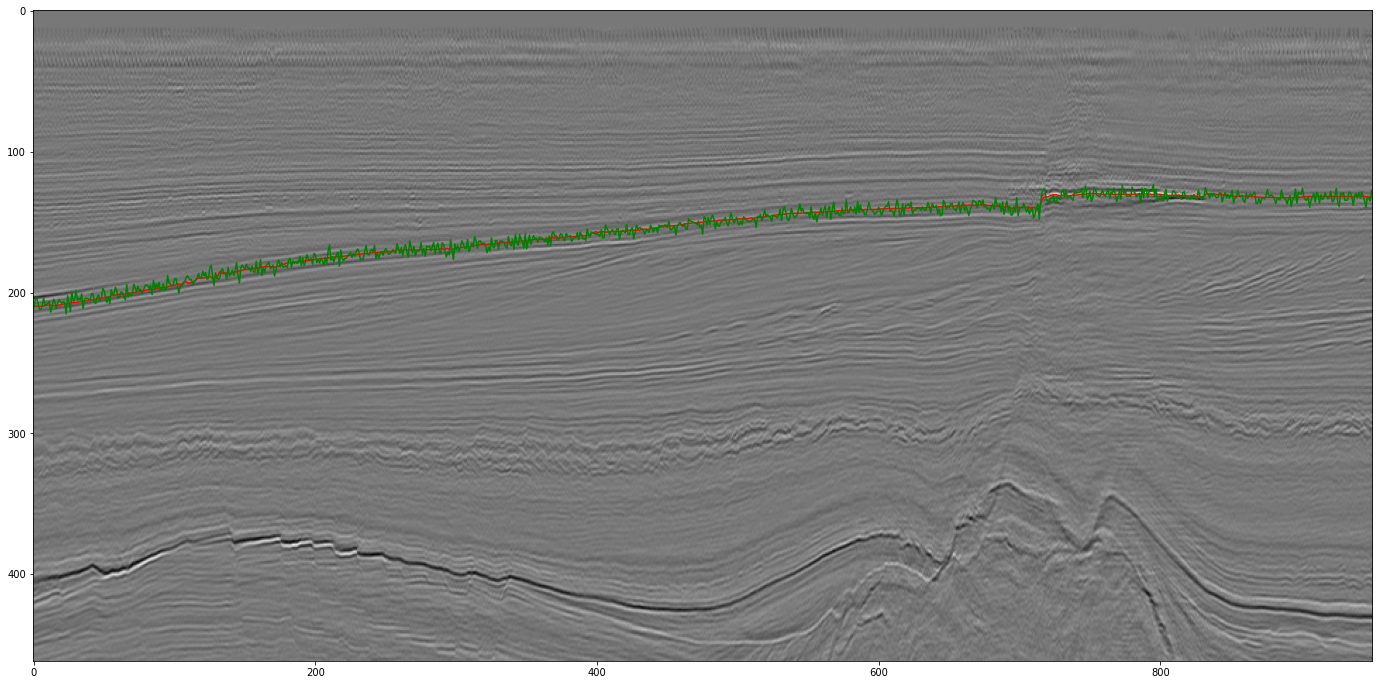

In [ ]:
inline = 100
prediction = np.transpose(lin.predict(data[inline,:,:]))

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(prediction, 'green')
plt.show()

as well as inline 110, which lies outside the training set:

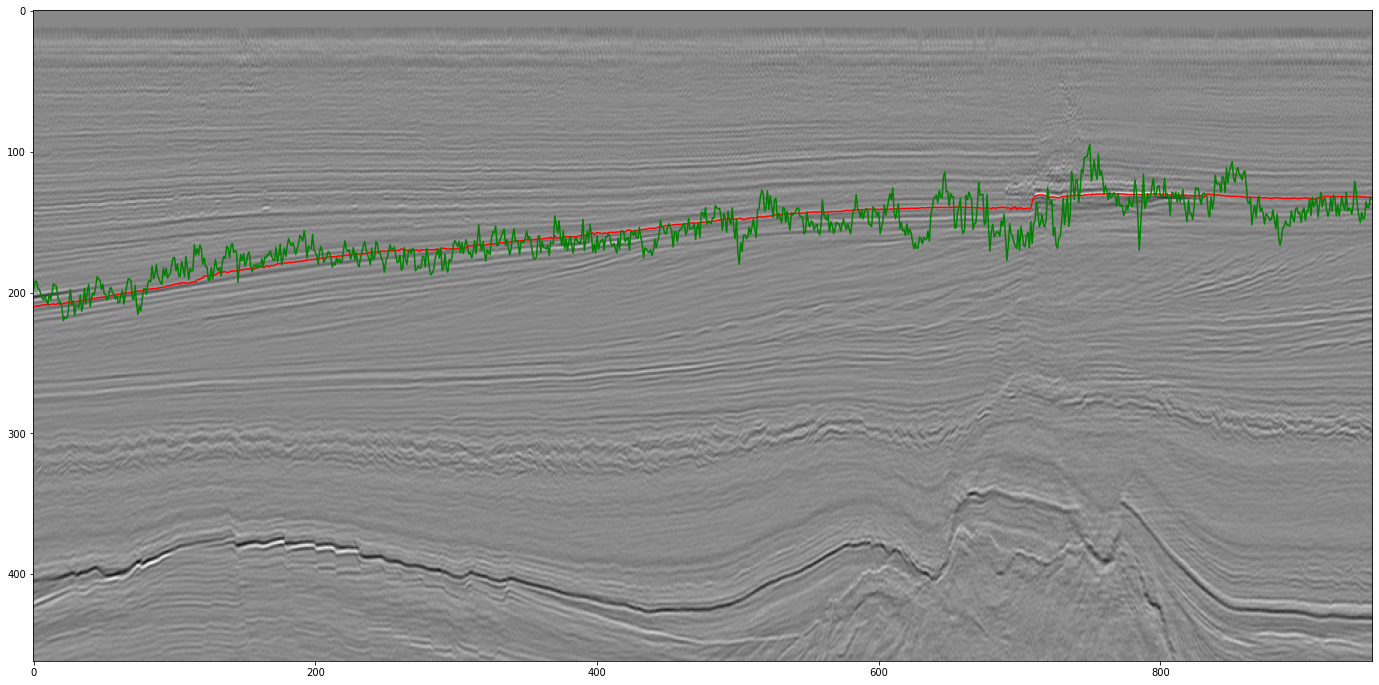

In [ ]:
inline = 110
prediction = np.transpose(lin.predict(data[inline,:,:]))

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(prediction, 'green')
plt.show()

Yeah, doesn't look great... let's try a more complex model!

# 1-D CNN #

Now we use a more complex model 1-D convolution neural network (CNN):

In [ ]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout



model = Sequential([Conv1D(filters=16, kernel_size=3, activation='relu', input_shape=(times,1)),
                    MaxPooling1D(),
                    Dropout(0.2),
                    Conv1D(filters=32, kernel_size=3, activation='relu'),
                    MaxPooling1D(),
                    Dropout(0.2),
                    Conv1D(filters=64, kernel_size=3, activation='relu'),
                    MaxPooling1D(),
                    Dropout(0.2),
                    Conv1D(filters=128, kernel_size=3, activation='relu'),
                    MaxPooling1D(),
                    Dropout(0.2),
                    Flatten(),
                    Dense(1024, activation='relu'),
                    Dense(1)])   


model.compile(loss='mean_absolute_error',
              optimizer='adam',
              metrics = ['mse'])


model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 460, 16)           64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 230, 16)           0         
_________________________________________________________________
dropout (Dropout)            (None, 230, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 228, 32)           1568      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 114, 32)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 114, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 112, 64)           6

For this model, we need a little more training data, so we use the traces from 40 inlines:

In [ ]:
lines = 40

X = data[100-lines//2:100+lines//2,:,:].reshape((lines*xlines,times))
X = np.expand_dims(X, axis=2)

y = t[100-lines//2:100+lines//2,:].reshape((lines*xlines))

We train our model over multiple epochs:

In [ ]:
history = model.fit(X,
                    y,
                    validation_split=0.2,
                    epochs=100)

Epoch 1/100
951/951 [==============================] - 36s 4ms/step - loss: 24.8145 - mse: 1641.0512 - val_loss: 42.2923 - val_mse: 1855.2422
Epoch 2/100
951/951 [==============================] - 4s 4ms/step - loss: 8.1909 - mse: 113.6158 - val_loss: 33.2895 - val_mse: 1139.6206
Epoch 3/100
951/951 [==============================] - 4s 4ms/step - loss: 6.0184 - mse: 65.1442 - val_loss: 27.1825 - val_mse: 761.6803
Epoch 4/100
951/951 [==============================] - 4s 4ms/step - loss: 5.1636 - mse: 48.4122 - val_loss: 17.6211 - val_mse: 330.0676
Epoch 5/100
951/951 [==============================] - 4s 4ms/step - loss: 4.0390 - mse: 30.1281 - val_loss: 10.1691 - val_mse: 114.5049
Epoch 6/100
951/951 [==============================] - 4s 4ms/step - loss: 3.4658 - mse: 22.1062 - val_loss: 6.8591 - val_mse: 53.6876
Epoch 7/100
951/951 [==============================] - 4s 4ms/step - loss: 3.1123 - mse: 17.1139 - val_loss: 2.6921 - val_mse: 11.7135
Epoch 8/100
951/951 [=================

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's look at inline 100 from the training set

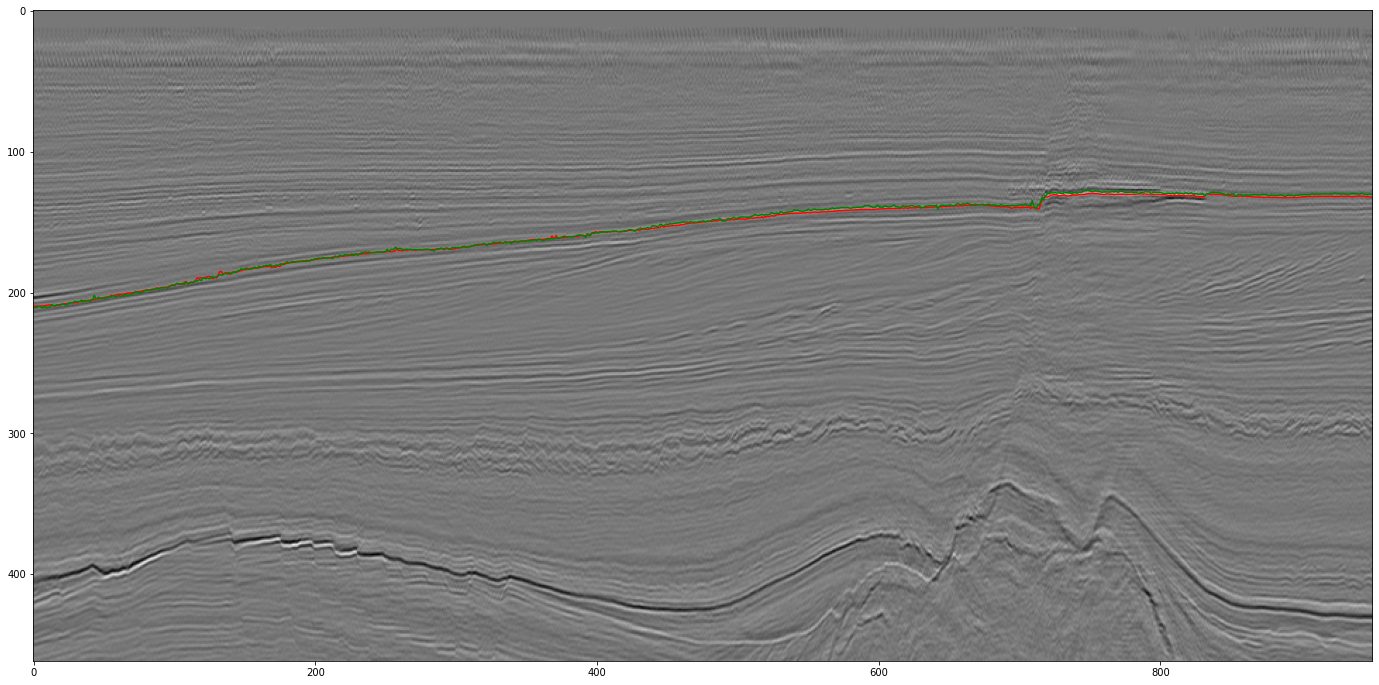

In [ ]:
inline = 100
prediction = model.predict(np.expand_dims(data[inline,:,:], axis=2))

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(prediction, 'green')
plt.show()

Not too bad... especially when we smooth out some of the peaks:

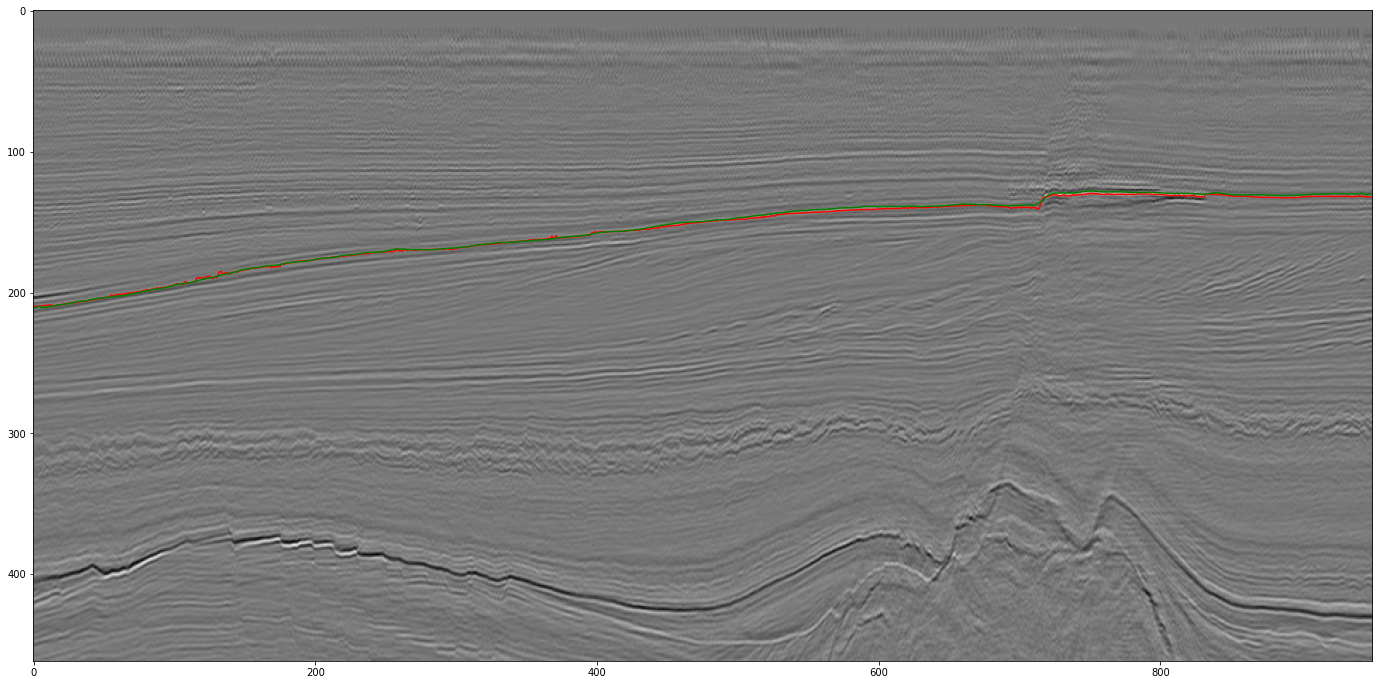

In [ ]:
factor = 10

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[:box_pts] = y[:box_pts]
    y_smooth[-box_pts:] = y[-box_pts:]
    return y_smooth


plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(smooth(prediction[:,0],factor), 'green')
plt.show()

Now let's look at a inline 130 outside of the training set:

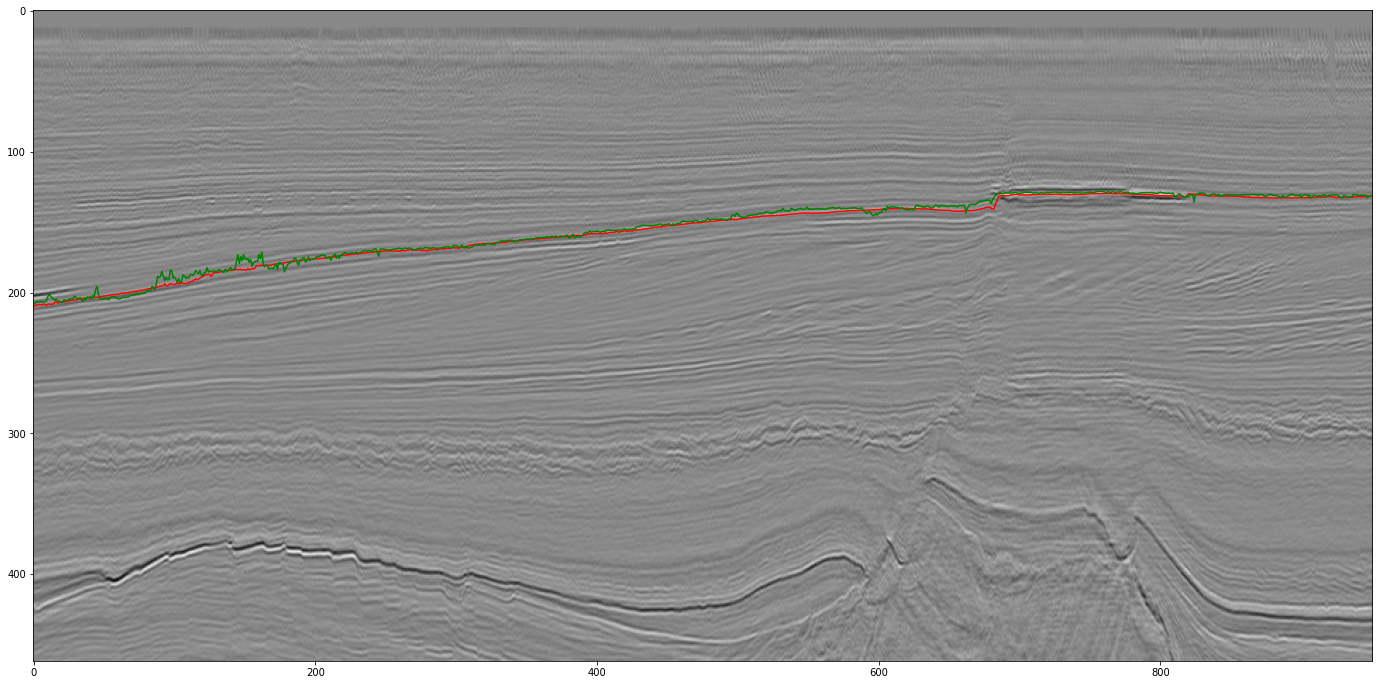

In [ ]:
inline = 130
prediction = model.predict(np.expand_dims(data[inline,:,:], axis=2))

plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(prediction, 'green')
plt.show()

with some smoothing:

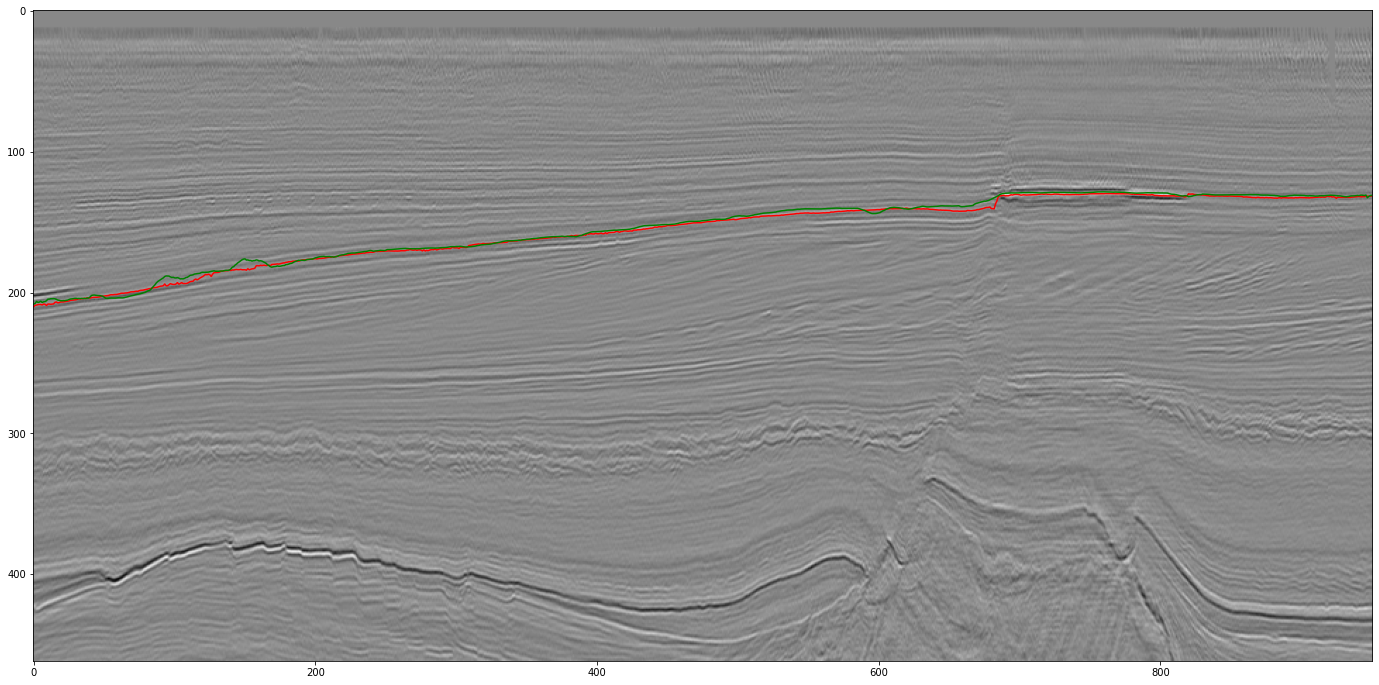

In [ ]:
factor = 10

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    y_smooth[:box_pts] = y[:box_pts]
    y_smooth[-box_pts:] = y[-box_pts:]
    return y_smooth


plt.figure(figsize=(24,24))
plt.imshow(np.transpose(data[inline,:,:]), 'gray')
plt.plot(t[inline,:], 'red')
plt.plot(smooth(prediction[:,0],factor), 'green')
plt.show()

That's okay, but let's compare the entire horizon:

In [ ]:
factor = 10

prediction = np.zeros_like(t)

for inline in range(inlines):
  prediction[inline] = smooth(model.predict(np.expand_dims(data[inline,:,:], axis=2))[:,0], factor)

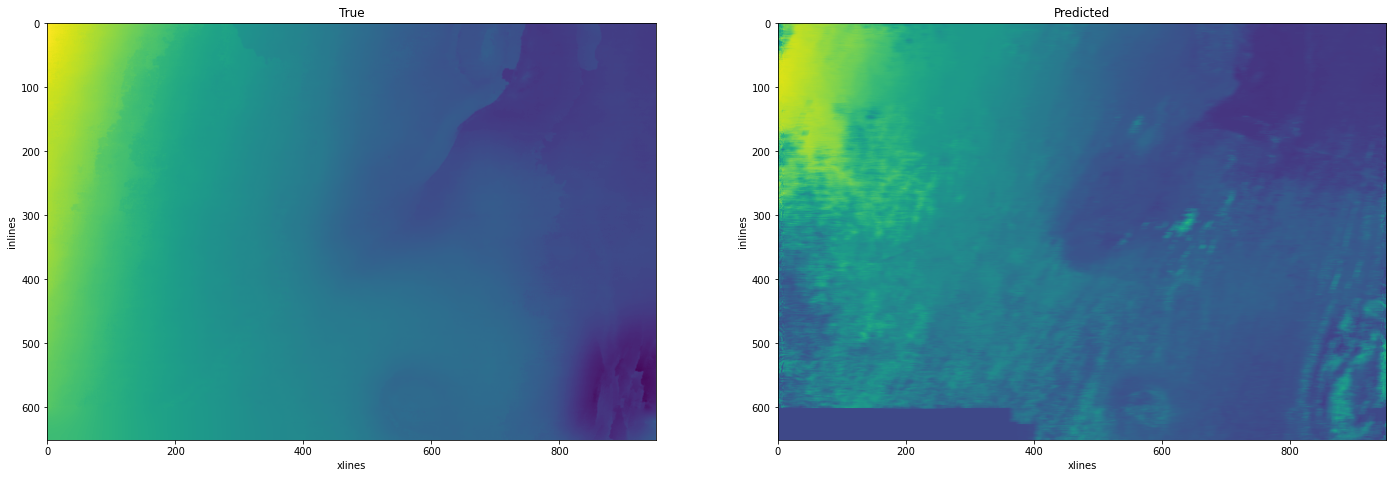

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(24,24))

axs[0].imshow(t)
axs[0].set_title('True')
axs[0].set_xlabel('xlines')
axs[0].set_ylabel('inlines')

im = axs[1].imshow(prediction, vmin=np.min(t), vmax=np.max(t))
axs[1].set_title('Predicted')
axs[1].set_xlabel('xlines')
axs[1].set_ylabel('inlines')

plt.show()

It looks like we are able to map the horizon to a first degree, but the level of detail isnt great, so let's see if we can improve upon this!